In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

print(f"TensorFlow Version: {tf.__version__}")

# --- 1. 加载内置数据集 ---
# Keras 会自动下载 Cifar-10 数据集
# x_train, x_test 是图像数据 (numpy 数组)
# y_train, y_test 是标签数据 (0-9 的整数)
print("Loading Cifar-10 dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 打印数据形状
# (50000, 32, 32, 3) -> 5万张训练图, 32x32像素, 3个颜色通道
print(f"Training data shape: {x_train.shape}") 
# (50000, 1) -> 5万个标签
print(f"Training labels shape: {y_train.shape}")


TensorFlow Version: 2.20.0
Loading Cifar-10 dataset...
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)


Normalizing data...
Showing sample images... Please close the plot window to continue training.


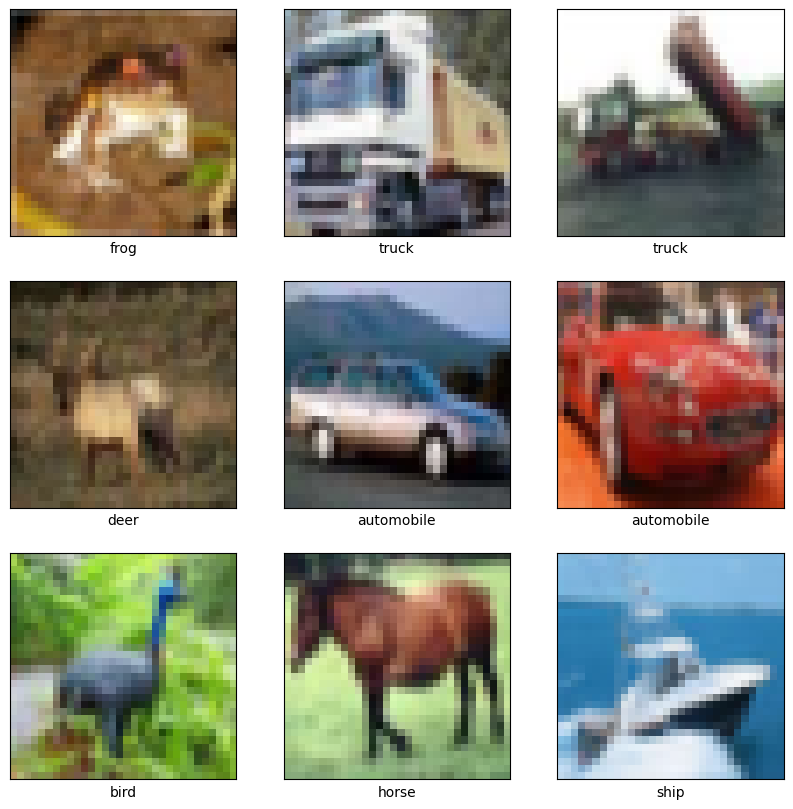

In [3]:

# --- 2. 数据预处理 ---
# 归一化: 将像素值从 [0, 255] 缩放到 [0, 1]
# 这是神经网络的标准操作
print("Normalizing data...")
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 定义10个类别的名称（Cifar-10 官方顺序）
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 让我们画几张图看看，确保数据加载正确
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # y_train[i] 是 [5], 我们需要 y_train[i][0] 来获取索引 5
    plt.xlabel(class_names[y_train[i][0]])
print("Showing sample images... Please close the plot window to continue training.")
plt.show()


In [4]:

# --- 3. 搭建你的第一个 CNN 模型 ---
# 这和你项目需要的基线模型 (Baseline) 结构几乎一样
print("Building model...")
model = models.Sequential()

# 输入层：告诉模型输入图像的形状
model.add(layers.Input(shape=(32, 32, 3)))

# 卷积层 (Conv2D): 提取特征 (32个滤镜)
# 激活函数 (relu): 增加非线性
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# 池化层 (MaxPooling2D): 压缩图像，减少计算量
model.add(layers.MaxPooling2D((2, 2)))

# 再来一个卷积-池化组合
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 展平层 (Flatten): 把 2D 图像数据 "压扁" 成 1D 向量
model.add(layers.Flatten())
# 全连接层 (Dense): 传统的神经网络层
model.add(layers.Dense(64, activation='relu'))

# 输出层 (Dense):
# 关键: 10个神经元 (对应10个类别)
# 关键: 'softmax' 激活函数 (输出10个类别的概率总和为1)
model.add(layers.Dense(10, activation='softmax'))

# 打印模型结构
model.summary()


Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,562 (654.54 KB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:

# --- 4. 编译模型 ---
# 在训练之前，我们需要配置模型
print("Compiling model...")
model.compile(
    optimizer='adam', # Adam 是一个高效且常用的优化器
    # 关键: 使用 'sparse_categorical_crossentropy'
    # 因为我们的标签 (y_train) 是整数 (0-9), 而不是 "one-hot" 编码
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] # 我们关心的是 "准确率"
)


Compiling model...


In [6]:

# --- 5. 训练模型 ---
print("Starting training... This may take a few minutes.")
# .fit() 就是“开始训练”
# 我们只训练 10 个周期 (epochs) 来快速查看结果
history = model.fit(
    x_train, 
    y_train, 
    epochs=10, 
    # 在每个周期结束后，用测试集评估一下模型
    validation_data=(x_test, y_test)
)

print("Training complete.")


Starting training... This may take a few minutes.
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.4612 - loss: 1.4958 - val_accuracy: 0.5653 - val_loss: 1.2404
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6066 - loss: 1.1244 - val_accuracy: 0.6123 - val_loss: 1.1105
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.6532 - loss: 0.9985 - val_accuracy: 0.6531 - val_loss: 1.0019
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.6814 - loss: 0.9151 - val_accuracy: 0.6409 - val_loss: 1.0210
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7070 - loss: 0.8502 - val_accuracy: 0.6835 - val_loss: 0.9273
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7225 - loss: 0.7990 - val_accuracy: 0.6905 - val_loss: 0.8978
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7402 - loss: 0.7483 - val_accuracy: 0.6918 - val_loss: 0.9146
Epoch 8/10
1563/1563 ━━━━━━━

Evaluating model on test data...
313/313 - 1s - 4ms/step - accuracy: 0.6969 - loss: 0.9376

Test accuracy: 0.6969


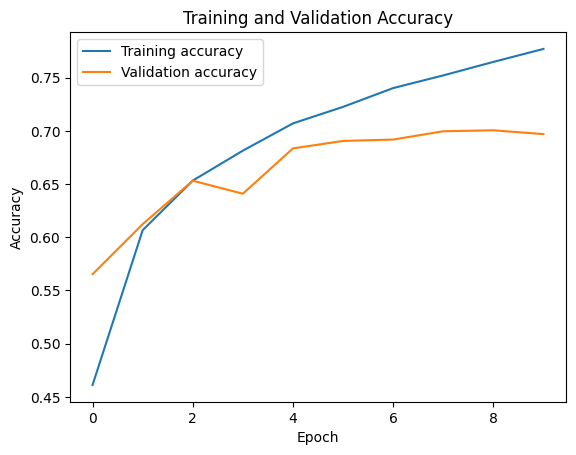

In [7]:

# --- 6. 评估模型 ---
# 在测试集上评估最终模型
print("Evaluating model on test data...")
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")

# 我们可以画出训练过程中的准确率变化
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()